In [19]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# Order book data EDA

In [20]:
path = r'./book_train.parquet/stock_id=0'


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def order_book_data_feature_construction(path):

    stock_id = path.split("=")[1]
    example_book_df = pd.read_parquet(path)

    # construct item for realized volatility calculation
    example_book_df.loc[:,('ask_spread')] = example_book_df['ask_size1'] - example_book_df['ask_size2']
    example_book_df.loc[:,('bid_spread')] = example_book_df['bid_size1'] - example_book_df['bid_size2']
    example_book_df.loc[:,('total_volume')] = example_book_df['ask_size1'] + example_book_df['ask_size2'] + example_book_df['bid_size1'] + example_book_df['bid_size2']
    example_book_df.loc[:,('volume_imbalance')] = abs(example_book_df['ask_size1'] + example_book_df['ask_size2'] - example_book_df['bid_size1'] - example_book_df['bid_size2'] )


    example_book_df.loc[:,('price_spread')] = (example_book_df['ask_price1']/example_book_df['bid_price1'])-1 # Constrcut Bid/Ask Spread.
    example_book_df.loc[:,('wap1')] = (example_book_df['bid_price1']*example_book_df['ask_size1'] + example_book_df['ask_price1']*example_book_df['bid_size1']) / (example_book_df['ask_size1'] + example_book_df['bid_size1'])
    example_book_df.loc[:,('wap2')] = (example_book_df['bid_price2']*example_book_df['ask_size2'] + example_book_df['ask_price2']*example_book_df['bid_size2']) / (example_book_df['ask_size2'] + example_book_df['bid_size2'])
    example_book_df.loc[:,('wap_balance')] = example_book_df['wap1'] - example_book_df['wap2']

    example_book_df.loc[:,('log_return1')] = example_book_df.groupby('time_id')['wap1'].transform(log_return)
    example_book_df.loc[:,('log_return2')] = example_book_df.groupby('time_id')['wap2'].transform(log_return)
    example_book_df = example_book_df[~example_book_df['log_return1'].isnull()] # drop the first null return value

    return example_book_df

example_book_df = order_book_data_feature_construction(path)
example_book_df

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,ask_spread,bid_spread,total_volume,volume_imbalance,price_spread,wap1,wap2,wap_balance,log_return1,log_return2
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,1,205,195,0.000878,1.001448,1.001390,0.000058,0.000014,0.000000
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1,205,195,0.000878,1.001448,1.001391,0.000057,0.000000,0.000001
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,26,1,231,221,0.000878,1.001443,1.001391,0.000052,-0.000005,0.000000
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,26,1,231,221,0.000878,1.001443,1.001391,0.000052,0.000000,0.000000
5,5,11,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1,205,195,0.000878,1.001448,1.001391,0.000057,0.000005,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,62,42,256,20,0.000480,0.998515,0.998522,-0.000008,0.000434,-0.000162
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,62,-109,409,173,0.000480,0.998516,0.998817,-0.000300,0.000001,0.000295
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,62,-9,309,73,0.000480,0.998516,0.998715,-0.000199,0.000000,-0.000101
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,62,-8,310,74,0.000480,0.998517,0.998715,-0.000198,0.000001,0.000000


In [21]:
create_feature_dict = {
        'log_return1':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean,],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap1':[np.mean],
        'wap2':[np.mean],
            }

df_feature = pd.DataFrame(example_book_df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
df_feature.columns = ['_'.join(col) for col in df_feature.columns]

df_feature 

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/3381476888.py:14: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature = pd.DataFrame(example_book_df.groupby(['time_id']).agg(create_feature_dict)).reset_index()


,time_id_,log_return1_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap1_mean,wap2_mean
0,5,0.004499,0.006999,0.000065,0.000852,-2.627907,-15.661130,134.275748,323.471761,1.003733,1.003668
1,11,0.001204,0.002476,0.000032,0.000393,53.864322,-24.221106,142.286432,411.733668,1.000240,1.000208
2,16,0.002369,0.004801,-0.000141,0.000725,-18.417112,57.807487,140.267380,416.310160,0.999541,0.999682
3,31,0.002574,0.003637,0.000195,0.000863,43.218487,-9.319328,147.394958,433.126050,0.998819,0.998624
4,62,0.001894,0.003257,-0.000008,0.000396,31.931429,41.668571,124.011429,344.457143,0.999616,0.999624
...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.002579,0.003821,0.000074,0.000553,49.608108,-25.956081,197.179054,374.733108,0.997936,0.997862
3826,32753,0.002206,0.002847,-0.000179,0.000543,-44.009756,107.297561,234.136585,621.424390,1.000312,1.000491
3827,32758,0.002913,0.003266,0.000094,0.000523,15.652406,-3.160428,116.449198,342.363636,0.999556,0.999462
3828,32763,0.003046,0.005105,-0.000029,0.000481,8.480392,-0.506536,132.241830,386.274510,1.002360,1.002389


- In usual financial market, we know trading volume is high in both opening hour and closing hour compare to other timing periods.

  Therefore, it might make sense to split the seconds in bucket and construct features

- First lets' see how many seconds in each time_id. 

  From the below plot, it make sense to split the seconds in bucket to >=150, >=300, >=450.

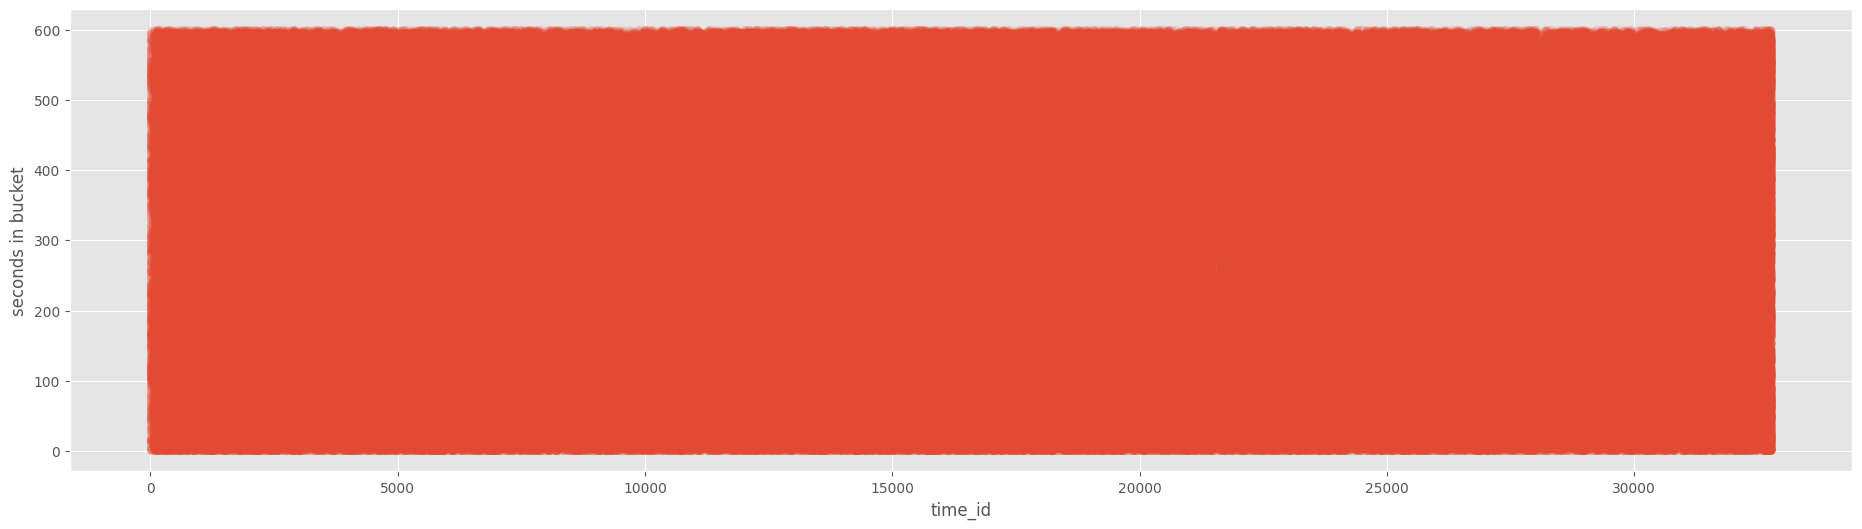

In [22]:
fig, ax = plt.subplots(figsize=(23,6))
ax.scatter(example_book_df['time_id'],example_book_df['seconds_in_bucket'],alpha=0.1)
ax.set_xlabel('time_id')
ax.set_ylabel('seconds in bucket')
plt.show()

In [23]:
seconds_in_bucket_interval = 150
times_interval = 0

for interval in range(4):

    print(times_interval)
    times_interval += seconds_in_bucket_interval
    

0
150
300
450


In [24]:
df_book_feature = pd.DataFrame()
seconds_in_bucket_interval = 150
times_interval = 0

for interval in range(4):
    
    df_feature_sec = example_book_df[(example_book_df['seconds_in_bucket'] >= times_interval) & (example_book_df['seconds_in_bucket'] <= times_interval+150)]
    df_feature_sec = df_feature_sec.groupby(['time_id']).agg(create_feature_dict).reset_index()
    df_feature_sec.columns = ['_'.join(col) + "_" + str(times_interval) for col in df_feature_sec.columns]
    df_feature_sec.columns = df_feature_sec.columns.str.replace('time_id__'+str(times_interval), 'time_id')

    if interval == 0:
        df_book_feature = df_feature_sec
    else:
        df_book_feature = pd.merge(df_book_feature,df_feature_sec,how='left',left_on='time_id',right_on='time_id')

    times_interval += seconds_in_bucket_interval

print(df_book_feature.columns)
df_book_feature

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/1481578129.py:8: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature_sec = df_feature_sec.groupby(['time_id']).agg(create_feature_dict).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/1481578129.py:8: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature_sec = df_feature_sec.groupby(['time_id']).agg(create_feature_dict).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/1481578129.py:8: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using Se

Index(['time_id', 'log_return1_realized_volatility_0',
       'log_return2_realized_volatility_0', 'wap_balance_mean_0',
       'price_spread_mean_0', 'bid_spread_mean_0', 'ask_spread_mean_0',
       'volume_imbalance_mean_0', 'total_volume_mean_0', 'wap1_mean_0',
       'wap2_mean_0', 'log_return1_realized_volatility_150',
       'log_return2_realized_volatility_150', 'wap_balance_mean_150',
       'price_spread_mean_150', 'bid_spread_mean_150', 'ask_spread_mean_150',
       'volume_imbalance_mean_150', 'total_volume_mean_150', 'wap1_mean_150',
       'wap2_mean_150', 'log_return1_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap1_mean_300',
       'wap2_mean_300', 'log_return1_realized_volatility_450',
       'log_return2_realized_volatility_450', 'wap_balance_mean_450',
       'price_spread_mean_

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/1481578129.py:8: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature_sec = df_feature_sec.groupby(['time_id']).agg(create_feature_dict).reset_index()


,time_id,log_return1_realized_volatility_0,log_return2_realized_volatility_0,wap_balance_mean_0,price_spread_mean_0,bid_spread_mean_0,ask_spread_mean_0,volume_imbalance_mean_0,total_volume_mean_0,wap1_mean_0,...,log_return1_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap1_mean_450,wap2_mean_450
0,5,0.002416,0.003456,0.000013,0.000830,-7.828571,-15.485714,168.685714,312.400000,1.003402,...,0.001721,0.004114,0.000075,0.000783,-11.823529,-18.705882,141.470588,263.941176,1.003482,1.003407
1,11,0.000575,0.001008,-0.000125,0.000659,-18.384615,16.769231,80.538462,361.538462,0.999839,...,0.000918,0.001883,0.000120,0.000348,58.685185,-56.555556,97.685185,447.981481,1.000518,1.000399
2,16,0.001019,0.002626,-0.000061,0.000805,-2.720588,6.661765,154.588235,394.911765,1.000267,...,0.001158,0.002972,-0.000244,0.000605,-47.818182,104.022727,156.113636,459.113636,0.998237,0.998481
3,31,0.001342,0.001586,0.000376,0.000739,84.921053,-65.526316,138.078947,452.078947,0.999575,...,0.000993,0.001424,-0.000345,0.001059,-80.444444,123.777778,146.000000,540.000000,0.998079,0.998424
4,62,0.001000,0.001429,0.000140,0.000399,73.425000,12.300000,98.825000,253.975000,0.999609,...,0.001378,0.000966,-0.000255,0.000520,-120.277778,59.277778,117.000000,391.944444,0.999518,0.999773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.000988,0.001518,-0.000071,0.000489,34.739130,36.565217,199.855072,456.376812,0.998435,...,0.001148,0.002048,0.000071,0.000425,58.076923,7.846154,227.153846,322.200000,0.996724,0.996653
3826,32753,0.001600,0.001537,-0.000090,0.000457,-84.724138,10.827586,184.172414,402.551724,0.999765,...,0.001146,0.001863,-0.000175,0.000572,14.804348,180.413043,234.217391,531.478261,1.000614,1.000789
3827,32758,0.001646,0.001277,0.000172,0.000544,10.351852,-58.833333,149.518519,414.333333,0.998819,...,0.001303,0.001972,0.000151,0.000470,49.370968,-12.935484,120.048387,331.177419,1.000342,1.000191
3828,32763,0.001509,0.002361,0.000008,0.000388,-0.896552,-36.287356,160.609195,378.724138,1.002559,...,0.001413,0.002180,0.000087,0.000519,50.723684,18.407895,121.394737,451.684211,1.002322,1.002234


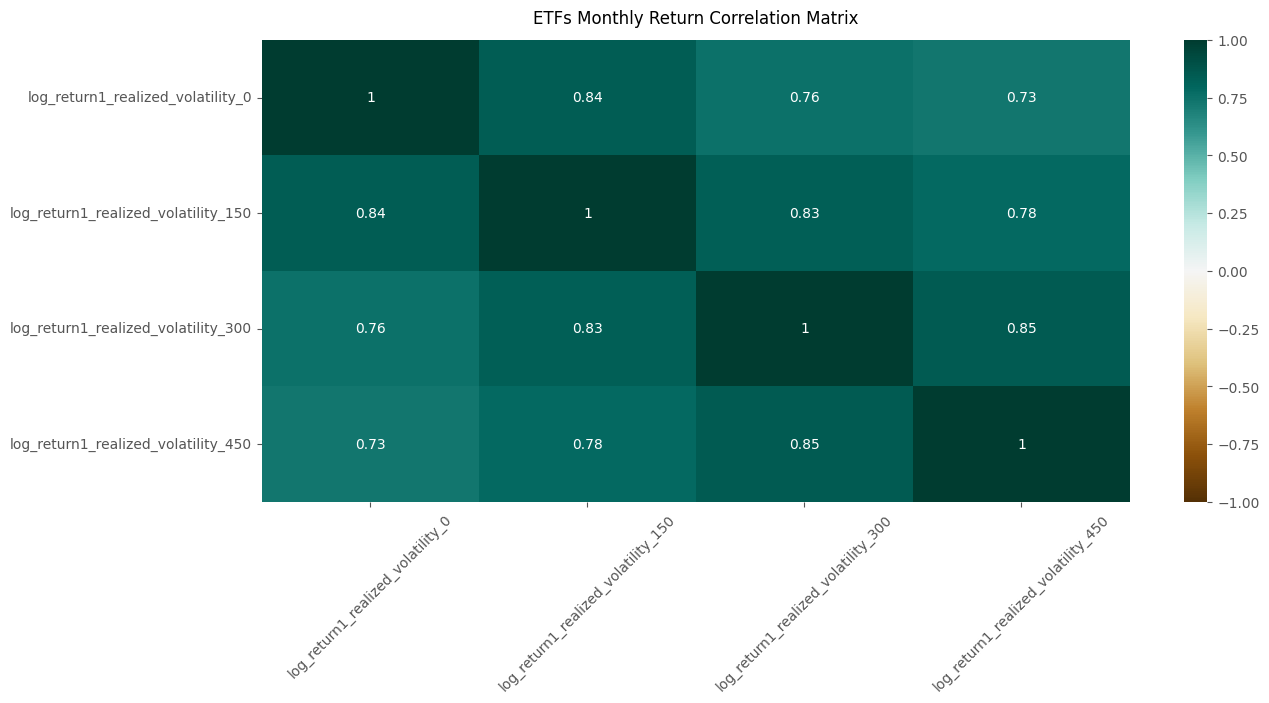

In [8]:
import seaborn as sns 

corr = df_book_feature[['log_return1_realized_volatility_0','log_return1_realized_volatility_150','log_return1_realized_volatility_300','log_return1_realized_volatility_450']].corr()

plt.figure(figsize=(14, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True , cmap='BrBG' )
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('ETFs Monthly Return Correlation Matrix', fontdict={'fontsize':12}, pad=12) ;
plt.xticks(rotation=45)
plt.show()

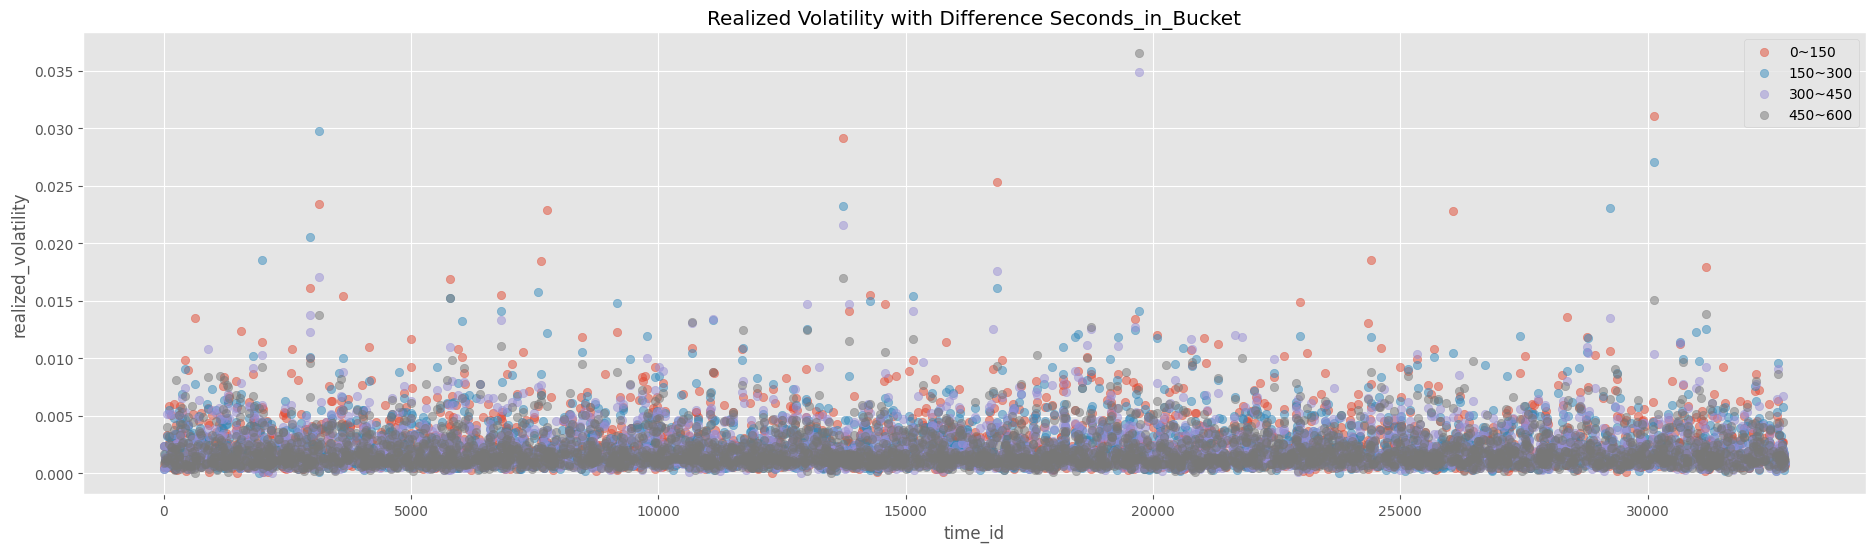

In [25]:
fig,ax = plt.subplots(figsize=(23,6))
ax.set_title('Realized Volatility with Difference Seconds_in_Bucket')
ax.scatter(df_book_feature['time_id'],df_book_feature['log_return1_realized_volatility_0'],alpha=0.5,label='0~150')
ax.scatter(df_book_feature['time_id'],df_book_feature['log_return1_realized_volatility_150'],alpha=0.5,label='150~300')
ax.scatter(df_book_feature['time_id'],df_book_feature['log_return1_realized_volatility_300'],alpha=0.5,label='300~450')
ax.scatter(df_book_feature['time_id'],df_book_feature['log_return1_realized_volatility_450'],alpha=0.5,label='450~600')
ax.set_xlabel('time_id')
ax.set_ylabel('realized_volatility')
plt.legend()
plt.show()

# Trade book data EDA

In [26]:
example_trade_book_df = pd.read_parquet(r'trade_train.parquet/stock_id=1/170b39f1f7144bb3b4554aabc336106e.parquet')
example_trade_book_df.columns = ['time_id','seconds_in_bucket','trade_price','trade_size','trade_order_count']
example_trade_book_df

,time_id,seconds_in_bucket,trade_price,trade_size,trade_order_count
0,5,28,1.002080,553,11
1,5,39,1.002460,8,3
2,5,42,1.002308,147,4
3,5,44,1.002788,1,1
4,5,51,1.002657,100,2
...,...,...,...,...,...
296205,32767,579,0.999010,81,3
296206,32767,587,0.999109,50,1
296207,32767,588,0.999010,126,2
296208,32767,592,0.999109,1,1


In [27]:
example_trade_book_df.loc[:,('trade_per_size')] = example_trade_book_df['trade_size'] / example_trade_book_df['trade_order_count']
example_trade_book_df.loc[:,('trade_log_return')] = example_trade_book_df.groupby('time_id')['trade_price'].transform(log_return)
example_trade_book_df = example_trade_book_df[~example_trade_book_df['trade_log_return'].isnull()] # drop the first null return value
example_trade_book_df

,time_id,seconds_in_bucket,trade_price,trade_size,trade_order_count,trade_per_size,trade_log_return
1,5,39,1.002460,8,3,2.666667,0.000379
2,5,42,1.002308,147,4,36.750000,-0.000152
3,5,44,1.002788,1,1,1.000000,0.000479
4,5,51,1.002657,100,2,50.000000,-0.000131
5,5,52,1.002723,20,1,20.000000,0.000066
...,...,...,...,...,...,...,...
296205,32767,579,0.999010,81,3,27.000000,-0.000087
296206,32767,587,0.999109,50,1,50.000000,0.000099
296207,32767,588,0.999010,126,2,63.000000,-0.000099
296208,32767,592,0.999109,1,1,1.000000,0.000099


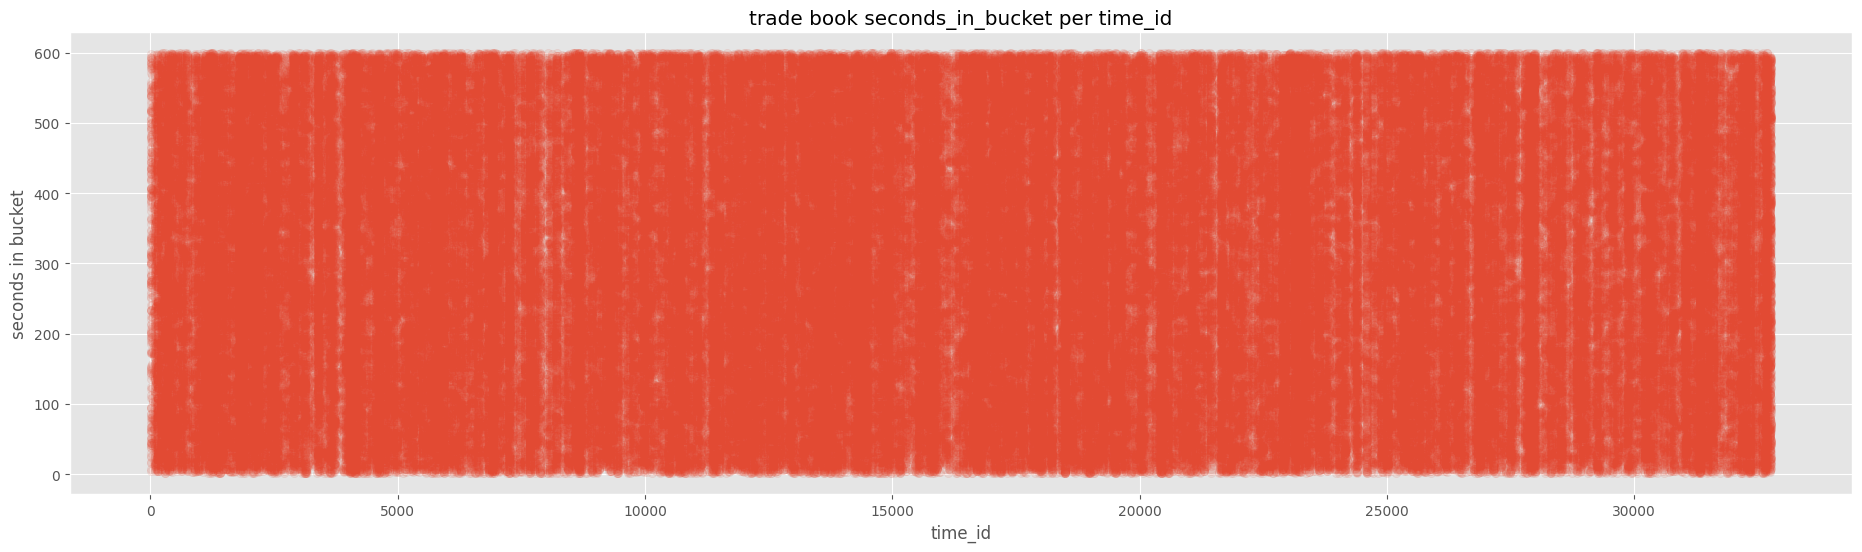

In [28]:
fig, ax = plt.subplots(figsize=(23,6))
ax.set_title('trade book seconds_in_bucket per time_id')
ax.scatter(example_trade_book_df['time_id'],example_trade_book_df['seconds_in_bucket'],alpha=0.1)
ax.set_xlabel('time_id')
ax.set_ylabel('seconds in bucket')
plt.show()

In [14]:
create_trade_book_feature_dict = {
        'trade_log_return':[realized_volatility],
        'trade_per_size':[np.mean],
        'trade_price':[np.mean],
        'trade_order_count':[np.mean],
        'trade_size':[np.mean],
            }

df_trade_feature = pd.DataFrame(example_trade_book_df.groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
df_trade_feature.columns = ['_'.join(col) for col in df_trade_feature.columns]

df_trade_feature 

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/785127031.py:9: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_trade_feature = pd.DataFrame(example_trade_book_df.groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()


,time_id_,trade_log_return_realized_volatility,trade_per_size_mean,trade_price_mean,trade_order_count_mean,trade_size_mean
0,5,0.003087,24.749878,1.003758,3.236559,101.666667
1,11,0.001700,26.015476,1.001911,2.795918,85.326531
2,16,0.001922,57.139408,1.001150,2.716049,135.802469
3,31,0.001735,19.532887,0.997576,2.281250,61.906250
4,62,0.001666,18.972222,1.000811,1.875000,44.250000
...,...,...,...,...,...,...
3825,32751,0.001776,16.449578,1.000115,2.750000,66.895833
3826,32753,0.008492,52.463125,1.008155,7.912088,416.939560
3827,32758,0.001927,41.424667,1.000836,2.680000,85.560000
3828,32763,0.002856,50.895385,1.003162,2.907407,152.296296


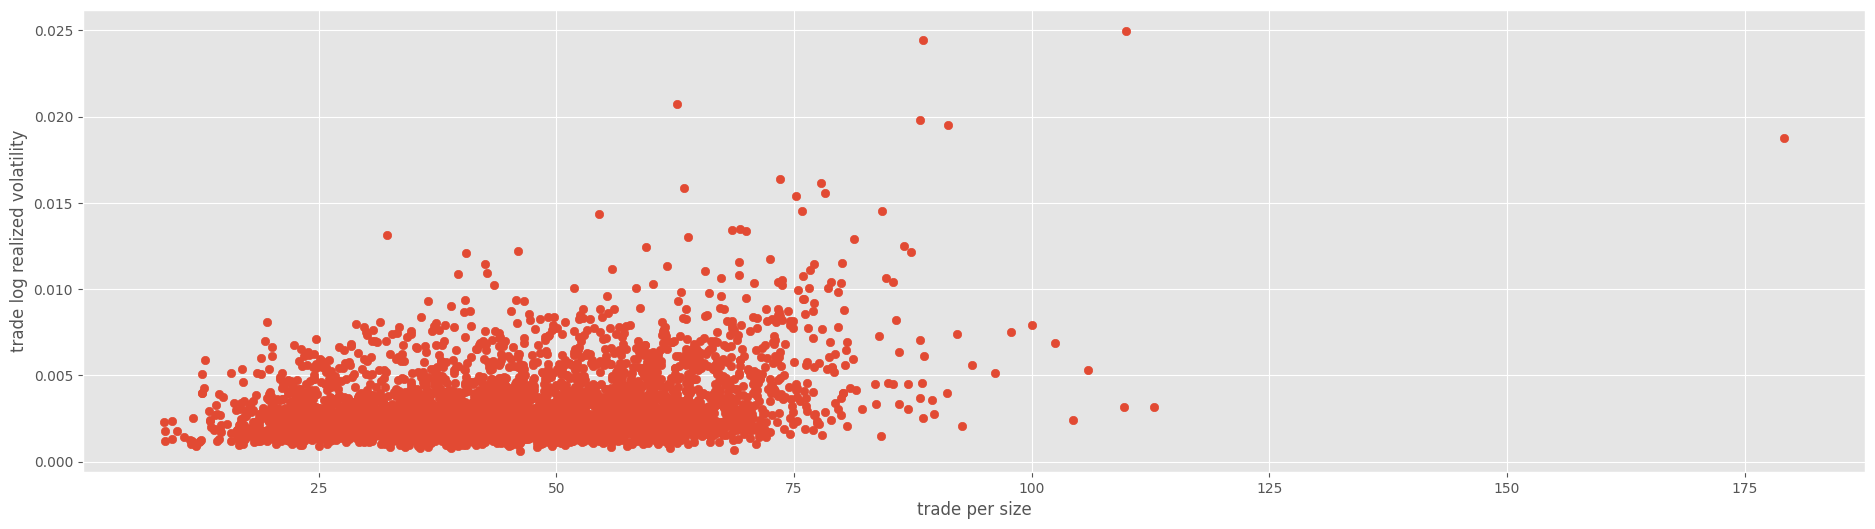

In [29]:
fig,ax = plt.subplots(figsize=(23,6))
ax.scatter(df_trade_feature['trade_per_size_mean'],df_trade_feature['trade_log_return_realized_volatility'])
ax.set_xlabel('trade per size')
ax.set_ylabel('trade log realized volatility')
plt.show()

In [30]:
df_trade_feature = pd.DataFrame()
seconds_in_bucket_interval = 150
times_interval = 0

for interval in range(4):
    
    df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
    df_trade_feature_sec.columns = ['_'.join(col) + "_" + str(times_interval) for col in df_trade_feature_sec.columns]
    df_trade_feature_sec.columns = df_trade_feature_sec.columns.str.replace('time_id__'+str(times_interval), 'time_id')

    if interval == 0:
        df_trade_feature = df_trade_feature_sec
    else:
        df_trade_feature = pd.merge(df_trade_feature,df_trade_feature_sec,how='left',left_on='time_id',right_on='time_id')

    times_interval += seconds_in_bucket_interval

print(df_trade_feature.columns)
df_trade_feature

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/300362106.py:7: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/300362106.py:7: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()


Index(['time_id', 'trade_log_return_realized_volatility_0',
       'trade_per_size_mean_0', 'trade_price_mean_0',
       'trade_order_count_mean_0', 'trade_size_mean_0',
       'trade_log_return_realized_volatility_150', 'trade_per_size_mean_150',
       'trade_price_mean_150', 'trade_order_count_mean_150',
       'trade_size_mean_150', 'trade_log_return_realized_volatility_300',
       'trade_per_size_mean_300', 'trade_price_mean_300',
       'trade_order_count_mean_300', 'trade_size_mean_300',
       'trade_log_return_realized_volatility_450', 'trade_per_size_mean_450',
       'trade_price_mean_450', 'trade_order_count_mean_450',
       'trade_size_mean_450'],
      dtype='object')


/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/300362106.py:7: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/300362106.py:7: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()


,time_id,trade_log_return_realized_volatility_0,trade_per_size_mean_0,trade_price_mean_0,trade_order_count_mean_0,trade_size_mean_0,trade_log_return_realized_volatility_150,trade_per_size_mean_150,trade_price_mean_150,trade_order_count_mean_150,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,5,0.003087,24.749878,1.003758,3.236559,101.666667,0.002754,25.646019,1.004001,3.141026,...,0.002130,20.567711,1.003527,3.244898,64.551020,0.001451,15.553788,1.003386,3.500000,64.590909
1,11,0.001700,26.015476,1.001911,2.795918,85.326531,0.001504,20.901126,1.001950,2.648649,...,0.001159,20.829167,1.002051,2.857143,77.392857,0.000802,24.951852,1.002018,3.000000,103.333333
2,16,0.001922,57.139408,1.001150,2.716049,135.802469,0.001723,54.621750,1.001491,2.968750,...,0.001625,57.598016,1.001670,2.880000,151.280000,0.000925,67.455357,1.001749,2.642857,170.000000
3,31,0.001735,19.532887,0.997576,2.281250,61.906250,0.001328,20.320563,0.997234,2.636364,...,0.001165,25.200000,0.996926,2.769231,81.538462,0.000871,25.100000,0.996921,2.818182,77.909091
4,62,0.001666,18.972222,1.000811,1.875000,44.250000,0.001634,22.105263,1.000884,2.000000,...,0.001168,15.904762,1.000801,1.857143,42.428571,0.000658,19.111111,1.000862,1.833333,47.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.001776,16.449578,1.000115,2.750000,66.895833,0.001585,18.245271,1.000110,3.027778,...,0.001280,20.530642,1.000165,3.608696,82.130435,0.000890,18.304563,1.000193,3.333333,66.916667
3826,32753,0.008492,52.463125,1.008155,7.912088,416.939560,0.007915,48.761134,1.010687,8.586207,...,0.006310,44.155094,1.012523,8.136364,350.659091,0.003531,47.760807,1.011895,6.410256,354.589744
3827,32758,0.001927,41.424667,1.000836,2.680000,85.560000,0.001804,39.767460,1.001051,2.666667,...,0.001567,41.737879,1.001213,2.727273,89.090909,0.001134,42.733333,1.001219,2.400000,97.400000
3828,32763,0.002856,50.895385,1.003162,2.907407,152.296296,0.002557,49.971283,1.003785,2.643678,...,0.001919,51.322710,1.004327,2.701754,145.157895,0.001494,48.529514,1.004053,2.656250,138.343750


# Join Features DataFrame

In [32]:
join_book_df = pd.merge(df_book_feature,df_trade_feature,left_on=['time_id'],right_on=['time_id'],how='left').fillna(value=0)
join_book_df

,time_id,log_return1_realized_volatility_0,log_return2_realized_volatility_0,wap_balance_mean_0,price_spread_mean_0,bid_spread_mean_0,ask_spread_mean_0,volume_imbalance_mean_0,total_volume_mean_0,wap1_mean_0,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,5,0.002416,0.003456,0.000013,0.000830,-7.828571,-15.485714,168.685714,312.400000,1.003402,...,0.002130,20.567711,1.003527,3.244898,64.551020,0.001451,15.553788,1.003386,3.500000,64.590909
1,11,0.000575,0.001008,-0.000125,0.000659,-18.384615,16.769231,80.538462,361.538462,0.999839,...,0.001159,20.829167,1.002051,2.857143,77.392857,0.000802,24.951852,1.002018,3.000000,103.333333
2,16,0.001019,0.002626,-0.000061,0.000805,-2.720588,6.661765,154.588235,394.911765,1.000267,...,0.001625,57.598016,1.001670,2.880000,151.280000,0.000925,67.455357,1.001749,2.642857,170.000000
3,31,0.001342,0.001586,0.000376,0.000739,84.921053,-65.526316,138.078947,452.078947,0.999575,...,0.001165,25.200000,0.996926,2.769231,81.538462,0.000871,25.100000,0.996921,2.818182,77.909091
4,62,0.001000,0.001429,0.000140,0.000399,73.425000,12.300000,98.825000,253.975000,0.999609,...,0.001168,15.904762,1.000801,1.857143,42.428571,0.000658,19.111111,1.000862,1.833333,47.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.000988,0.001518,-0.000071,0.000489,34.739130,36.565217,199.855072,456.376812,0.998435,...,0.001280,20.530642,1.000165,3.608696,82.130435,0.000890,18.304563,1.000193,3.333333,66.916667
3826,32753,0.001600,0.001537,-0.000090,0.000457,-84.724138,10.827586,184.172414,402.551724,0.999765,...,0.006310,44.155094,1.012523,8.136364,350.659091,0.003531,47.760807,1.011895,6.410256,354.589744
3827,32758,0.001646,0.001277,0.000172,0.000544,10.351852,-58.833333,149.518519,414.333333,0.998819,...,0.001567,41.737879,1.001213,2.727273,89.090909,0.001134,42.733333,1.001219,2.400000,97.400000
3828,32763,0.001509,0.002361,0.000008,0.000388,-0.896552,-36.287356,160.609195,378.724138,1.002559,...,0.001919,51.322710,1.004327,2.701754,145.157895,0.001494,48.529514,1.004053,2.656250,138.343750


# Function and pipeline all the process

- book data

In [33]:
path = r'./book_train.parquet/stock_id=0'


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def order_book_data_feature_construction(path):

    stock_id = path.split("=")[1]
    example_book_df = pd.read_parquet(path)

    # construct item for realized volatility calculation
    example_book_df.loc[:,('ask_spread')] = example_book_df['ask_size1'] - example_book_df['ask_size2']
    example_book_df.loc[:,('bid_spread')] = example_book_df['bid_size1'] - example_book_df['bid_size2']
    example_book_df.loc[:,('total_volume')] = example_book_df['ask_size1'] + example_book_df['ask_size2'] + example_book_df['bid_size1'] + example_book_df['bid_size2']
    example_book_df.loc[:,('volume_imbalance')] = abs(example_book_df['ask_size1'] + example_book_df['ask_size2'] - example_book_df['bid_size1'] - example_book_df['bid_size2'] )


    example_book_df.loc[:,('price_spread')] = (example_book_df['ask_price1']/example_book_df['bid_price1'])-1 # Constrcut Bid/Ask Spread.
    example_book_df.loc[:,('wap1')] = (example_book_df['bid_price1']*example_book_df['ask_size1'] + example_book_df['ask_price1']*example_book_df['bid_size1']) / (example_book_df['ask_size1'] + example_book_df['bid_size1'])
    example_book_df.loc[:,('wap2')] = (example_book_df['bid_price2']*example_book_df['ask_size2'] + example_book_df['ask_price2']*example_book_df['bid_size2']) / (example_book_df['ask_size2'] + example_book_df['bid_size2'])
    example_book_df.loc[:,('wap_balance')] = example_book_df['wap1'] - example_book_df['wap2']

    example_book_df.loc[:,('log_return1')] = example_book_df.groupby('time_id')['wap1'].transform(log_return)
    example_book_df.loc[:,('log_return2')] = example_book_df.groupby('time_id')['wap2'].transform(log_return)
    example_book_df = example_book_df[~example_book_df['log_return1'].isnull()] # drop the first null return value

    return example_book_df


def book_data_preprocess_per_stock(path):

    stock_id = path.split("=")[1]
    example_book_df = order_book_data_feature_construction(path)

    create_feature_dict = {
            'log_return1':[realized_volatility],
            'log_return2':[realized_volatility],
            'wap_balance':[np.mean,],
            'price_spread':[np.mean],
            'bid_spread':[np.mean],
            'ask_spread':[np.mean],
            'volume_imbalance':[np.mean],
            'total_volume':[np.mean],
            'wap1':[np.mean],
            'wap2':[np.mean],
                }

    df_feature = pd.DataFrame(example_book_df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    df_book_feature = pd.DataFrame()
    seconds_in_bucket_interval = 150
    times_interval = 0

    for interval in range(4):
        
        df_feature_sec = pd.DataFrame(example_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_feature_dict)).reset_index()
        df_feature_sec.columns = ['_'.join(col) + "_" + str(times_interval) for col in df_feature_sec.columns]
        df_feature_sec.columns = df_feature_sec.columns.str.replace('time_id__'+str(times_interval), 'time_id')

        if interval == 0:
            df_book_feature = df_feature_sec
        else:
            df_book_feature = pd.merge(df_book_feature,df_feature_sec,how='left',left_on='time_id',right_on='time_id')
        
        times_interval += seconds_in_bucket_interval

    df_book_feature.insert(0,'row_id' ,[f'{stock_id}-{x}' for x in df_book_feature['time_id'].to_list()])
    df_book_feature = df_book_feature.drop(['time_id'],axis=1)

    return df_book_feature


book_data_preprocess_per_stock(path)

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:52: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature = pd.DataFrame(example_book_df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:61: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature_sec = pd.DataFrame(example_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_feature_dict)).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:61: FutureWarnin

,row_id,log_return1_realized_volatility_0,log_return2_realized_volatility_0,wap_balance_mean_0,price_spread_mean_0,bid_spread_mean_0,ask_spread_mean_0,volume_imbalance_mean_0,total_volume_mean_0,wap1_mean_0,...,log_return1_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap1_mean_450,wap2_mean_450
0,0-5,0.004499,0.006999,0.000065,0.000852,-2.627907,-15.661130,134.275748,323.471761,1.003733,...,0.001721,0.004114,0.000075,0.000783,-11.823529,-18.705882,141.470588,263.941176,1.003482,1.003407
1,0-11,0.001204,0.002476,0.000032,0.000393,53.864322,-24.221106,142.286432,411.733668,1.000240,...,0.000918,0.001883,0.000120,0.000348,58.685185,-56.555556,97.685185,447.981481,1.000518,1.000399
2,0-16,0.002369,0.004801,-0.000141,0.000725,-18.417112,57.807487,140.267380,416.310160,0.999541,...,0.001158,0.002972,-0.000244,0.000605,-47.818182,104.022727,156.113636,459.113636,0.998237,0.998481
3,0-31,0.002574,0.003637,0.000195,0.000863,43.218487,-9.319328,147.394958,433.126050,0.998819,...,0.000993,0.001424,-0.000345,0.001059,-80.444444,123.777778,146.000000,540.000000,0.998079,0.998424
4,0-62,0.001894,0.003257,-0.000008,0.000396,31.931429,41.668571,124.011429,344.457143,0.999616,...,0.001378,0.000966,-0.000255,0.000520,-120.277778,59.277778,117.000000,391.944444,0.999518,0.999773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0-32751,0.002579,0.003821,0.000074,0.000553,49.608108,-25.956081,197.179054,374.733108,0.997936,...,0.001148,0.002048,0.000071,0.000425,58.076923,7.846154,227.153846,322.200000,0.996724,0.996653
3826,0-32753,0.002206,0.002847,-0.000179,0.000543,-44.009756,107.297561,234.136585,621.424390,1.000312,...,0.001146,0.001863,-0.000175,0.000572,14.804348,180.413043,234.217391,531.478261,1.000614,1.000789
3827,0-32758,0.002913,0.003266,0.000094,0.000523,15.652406,-3.160428,116.449198,342.363636,0.999556,...,0.001303,0.001972,0.000151,0.000470,49.370968,-12.935484,120.048387,331.177419,1.000342,1.000191
3828,0-32763,0.003046,0.005105,-0.000029,0.000481,8.480392,-0.506536,132.241830,386.274510,1.002360,...,0.001413,0.002180,0.000087,0.000519,50.723684,18.407895,121.394737,451.684211,1.002322,1.002234


- trade data

In [34]:
trade_path = r'trade_train.parquet/stock_id=0'

def trade_book_data_feature_construction(path):

    example_trade_book_df = pd.read_parquet(path)
    example_trade_book_df.columns = ['time_id','seconds_in_bucket','trade_price','trade_size','trade_order_count']


    example_trade_book_df.loc[:,('trade_per_size')] = example_trade_book_df['trade_size'] / example_trade_book_df['trade_order_count']
    example_trade_book_df.loc[:,('trade_log_return')] = example_trade_book_df.groupby('time_id')['trade_price'].transform(log_return)
    example_trade_book_df = example_trade_book_df[~example_trade_book_df['trade_log_return'].isnull()] # drop the first null return value

    return example_trade_book_df


def trade_data_preprocess_per_stock(path):

    stock_id = path.split("=")[1]
    example_trade_book_df = trade_book_data_feature_construction(path)

    create_trade_book_feature_dict = {
            'trade_log_return':[realized_volatility],
            'trade_per_size':[np.mean],
            'trade_price':[np.mean],
            'trade_order_count':[np.mean],
            'trade_size':[np.mean],
                }

    df_trade_feature = pd.DataFrame(example_trade_book_df.groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
    df_trade_feature.columns = ['_'.join(col) for col in df_trade_feature.columns]

    df_trade_feature = pd.DataFrame()
    seconds_in_bucket_interval = 150
    times_interval = 0

    for interval in range(4):
        
        df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
        df_trade_feature_sec.columns = ['_'.join(col) + "_" + str(times_interval) for col in df_trade_feature_sec.columns]
        df_trade_feature_sec.columns = df_trade_feature_sec.columns.str.replace('time_id__'+str(times_interval), 'time_id')

        if interval == 0:
            df_trade_feature = df_trade_feature_sec
        else:
            df_trade_feature = pd.merge(df_trade_feature,df_trade_feature_sec,how='left',left_on='time_id',right_on='time_id')
        
        times_interval += seconds_in_bucket_interval

    df_trade_feature.insert(0,'row_id' ,[f'{stock_id}-{x}' for x in df_trade_feature['time_id'].to_list()])
    df_trade_feature = df_trade_feature.drop(['time_id'],axis=1)

    return df_trade_feature

trade_data_preprocess_per_stock(trade_path)

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/1131083550.py:29: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_trade_feature = pd.DataFrame(example_trade_book_df.groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/1131083550.py:38: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_trade_feature_sec = pd.DataFrame(example_trade_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_trade_book_feature_dict)).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T

,row_id,trade_log_return_realized_volatility_0,trade_per_size_mean_0,trade_price_mean_0,trade_order_count_mean_0,trade_size_mean_0,trade_log_return_realized_volatility_150,trade_per_size_mean_150,trade_price_mean_150,trade_order_count_mean_150,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,0-5,0.002006,23.014225,1.003759,2.512821,73.153846,0.001701,21.876825,1.003777,2.433333,...,0.001308,18.628798,1.003679,2.571429,75.571429,0.001060,16.764626,1.003417,2.642857,74.428571
1,0-11,0.000901,20.718391,1.000219,1.896552,44.379310,0.000813,22.576389,1.000285,2.041667,...,0.000587,26.822917,1.000392,2.250000,56.250000,0.000501,39.966667,1.000488,2.200000,82.800000
2,0-16,0.001961,26.529663,0.999162,2.791667,89.958333,0.001621,29.298095,0.998961,2.950000,...,0.001137,27.236111,0.998508,3.166667,99.083333,0.001048,32.240741,0.998130,3.666667,120.555556
3,0-31,0.001561,34.972222,0.998933,4.142857,139.214286,0.001401,30.904040,0.998712,4.545455,...,0.001089,34.623457,0.998780,5.111111,172.888889,0.000802,30.250000,0.998106,3.666667,171.333333
4,0-62,0.000871,16.899969,0.999599,4.190476,85.238095,0.000550,17.663848,0.999625,4.500000,...,0.000453,19.656506,0.999555,4.909091,110.818182,0.000360,2.725000,0.999547,3.500000,10.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0-32751,0.001519,17.157532,0.997544,3.019608,67.039216,0.001409,18.834146,0.997368,3.238095,...,0.001162,19.163118,0.997196,3.257143,67.571429,0.000786,25.039912,0.996757,2.947368,61.000000
3826,0-32753,0.001411,27.839035,1.000344,3.814815,153.148148,0.001284,24.024123,1.000564,3.421053,...,0.001066,33.454861,1.000721,4.250000,180.083333,0.000750,35.733333,1.000757,4.600000,231.600000
3827,0-32758,0.001521,34.970649,0.999657,3.571429,121.400000,0.001375,32.458866,0.999899,3.444444,...,0.001242,32.324518,1.000083,3.727273,104.272727,0.000780,29.437500,1.000482,2.000000,52.000000
3828,0-32763,0.001794,29.229647,1.002319,2.173077,61.826923,0.001650,29.478009,1.002237,2.055556,...,0.001404,33.391667,1.002254,1.920000,65.080000,0.001012,53.649306,1.002340,2.666667,117.916667


In [35]:
def main_data_preprocess(book_path,trade_path):

    df_book_features = book_data_preprocess_per_stock(book_path)
    df_trade_features = trade_data_preprocess_per_stock(trade_path)

    return pd.merge(df_book_features,df_trade_features,how='left',left_on='row_id',right_on='row_id')


book_path = r'./book_train.parquet/stock_id=0'
trade_path = r'trade_train.parquet/stock_id=0'


feature_per_stock = main_data_preprocess(book_path,trade_path)
feature_per_stock

/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:52: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature = pd.DataFrame(example_book_df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:61: FutureWarning: The provided callable <function mean at 0x1067d1280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_feature_sec = pd.DataFrame(example_book_df.query(f'seconds_in_bucket >= {times_interval}').groupby(['time_id']).agg(create_feature_dict)).reset_index()
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:61: FutureWarnin

,row_id,log_return1_realized_volatility_0,log_return2_realized_volatility_0,wap_balance_mean_0,price_spread_mean_0,bid_spread_mean_0,ask_spread_mean_0,volume_imbalance_mean_0,total_volume_mean_0,wap1_mean_0,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,0-5,0.004499,0.006999,0.000065,0.000852,-2.627907,-15.661130,134.275748,323.471761,1.003733,...,0.001308,18.628798,1.003679,2.571429,75.571429,0.001060,16.764626,1.003417,2.642857,74.428571
1,0-11,0.001204,0.002476,0.000032,0.000393,53.864322,-24.221106,142.286432,411.733668,1.000240,...,0.000587,26.822917,1.000392,2.250000,56.250000,0.000501,39.966667,1.000488,2.200000,82.800000
2,0-16,0.002369,0.004801,-0.000141,0.000725,-18.417112,57.807487,140.267380,416.310160,0.999541,...,0.001137,27.236111,0.998508,3.166667,99.083333,0.001048,32.240741,0.998130,3.666667,120.555556
3,0-31,0.002574,0.003637,0.000195,0.000863,43.218487,-9.319328,147.394958,433.126050,0.998819,...,0.001089,34.623457,0.998780,5.111111,172.888889,0.000802,30.250000,0.998106,3.666667,171.333333
4,0-62,0.001894,0.003257,-0.000008,0.000396,31.931429,41.668571,124.011429,344.457143,0.999616,...,0.000453,19.656506,0.999555,4.909091,110.818182,0.000360,2.725000,0.999547,3.500000,10.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0-32751,0.002579,0.003821,0.000074,0.000553,49.608108,-25.956081,197.179054,374.733108,0.997936,...,0.001162,19.163118,0.997196,3.257143,67.571429,0.000786,25.039912,0.996757,2.947368,61.000000
3826,0-32753,0.002206,0.002847,-0.000179,0.000543,-44.009756,107.297561,234.136585,621.424390,1.000312,...,0.001066,33.454861,1.000721,4.250000,180.083333,0.000750,35.733333,1.000757,4.600000,231.600000
3827,0-32758,0.002913,0.003266,0.000094,0.000523,15.652406,-3.160428,116.449198,342.363636,0.999556,...,0.001242,32.324518,1.000083,3.727273,104.272727,0.000780,29.437500,1.000482,2.000000,52.000000
3828,0-32763,0.003046,0.005105,-0.000029,0.000481,8.480392,-0.506536,132.241830,386.274510,1.002360,...,0.001404,33.391667,1.002254,1.920000,65.080000,0.001012,53.649306,1.002340,2.666667,117.916667


# Joblib parallel conputing every stock features.

- list of stock id

In [36]:
import glob

list_order_book_file_train = glob.glob(r'./book_train.parquet/*')
list_stock_ids = [ path.split("=")[1] for path in list_order_book_file_train]

print(list_stock_ids)

['17', '28', '10', '26', '19', '21', '75', '81', '86', '72', '44', '88', '43', '20', '27', '18', '11', '16', '29', '89', '42', '73', '87', '80', '74', '103', '104', '105', '102', '120', '118', '111', '116', '110', '119', '126', '7', '56', '69', '51', '0', '67', '93', '58', '9', '94', '60', '34', '33', '61', '95', '66', '8', '59', '1', '50', '6', '68', '32', '35', '85', '76', '82', '40', '78', '47', '13', '14', '22', '46', '41', '48', '83', '77', '70', '84', '23', '15', '107', '100', '109', '108', '101', '124', '123', '115', '112', '113', '114', '122', '125', '30', '37', '39', '52', '3', '99', '4', '55', '97', '63', '64', '90', '38', '36', '31', '62', '96', '5', '2', '53', '98']


In [37]:
from joblib import Parallel, delayed

# File Case for data path file case !
data_dir = r'./'

# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids):

    def for_joblib(stock_id):
        """
        把每一個 unique stock id 需要處理的放在這裡
        """

        book_path  = data_dir + "book_train.parquet/stock_id="  + str(stock_id)
        trade_path = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)

        feature_per_stock = main_data_preprocess(book_path,trade_path)

        return feature_per_stock

    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    df = pd.concat(df,ignore_index=True)

    return df.sort_values(by='row_id')
    
train_features_df = preprocessor(list_stock_ids)
train_features_df 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:52: FutureWarning: The provided callable <function mean at 0x1036d2040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:52: FutureWarning: The provided callable <function mean at 0x1013de040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
/var/folders/zd/q7f9xjns6w54_qqsgjmv_16r0000gn/T/ipykernel_6847/2472733081.py:52: FutureWarning: The provided callable <function mean at 0x10633e040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep curren

,row_id,log_return1_realized_volatility_0,log_return2_realized_volatility_0,wap_balance_mean_0,price_spread_mean_0,bid_spread_mean_0,ask_spread_mean_0,volume_imbalance_mean_0,total_volume_mean_0,wap1_mean_0,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
153292,0-1000,0.001731,0.004370,6.220178e-05,0.000445,35.950920,19.932515,143.061350,290.680982,0.998795,...,0.000908,15.328571,0.998402,2.142857,34.142857,0.000644,16.120000,0.998464,3.000000,43.000000
154374,0-10000,0.002863,0.004082,-2.808591e-05,0.000461,-35.936842,-7.589474,148.192982,370.445614,0.999884,...,0.001083,22.169048,1.000283,3.428571,86.714286,0.000733,22.333333,1.000144,2.333333,81.000000
154375,0-10005,0.008673,0.013693,1.362336e-04,0.002113,24.928962,-15.721311,109.502732,333.338798,1.001308,...,0.002449,12.886724,1.002050,3.416667,79.916667,0.002223,12.996753,1.001380,4.000000,84.375000
154376,0-10017,0.014300,0.019203,1.099671e-04,0.003557,-29.185022,32.810573,166.348018,380.215859,0.996158,...,0.007005,30.191122,1.000240,3.950000,108.150000,0.005085,19.033814,0.998491,4.416667,71.833333
154377,0-10030,0.002503,0.004478,-9.844954e-06,0.000624,19.025907,45.471503,88.310881,325.678756,0.999461,...,0.001090,34.142857,0.999041,2.000000,90.071429,0.000941,48.666667,0.999022,2.142857,117.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368847,99-9972,0.001629,0.002200,-9.263037e-06,0.000218,-290.316888,-299.654649,510.032258,2459.311195,1.002490,...,0.000987,70.907540,1.003342,3.226415,256.018868,0.000768,65.187821,1.003537,2.730769,220.384615
368848,99-9973,0.009243,0.013491,1.853269e-06,0.000701,-8.414449,-68.642586,330.091255,836.444867,1.005890,...,0.004671,74.775854,1.006534,4.553398,359.893204,0.003244,71.710942,1.005701,4.581818,362.563636
368849,99-9976,0.005455,0.006021,-2.215730e-07,0.000512,-96.512295,-2.020492,585.770492,1033.549180,0.992295,...,0.002327,62.092654,0.990129,3.472527,258.879121,0.001678,55.321170,0.989176,3.854545,245.218182
368850,99-9988,0.001239,0.001573,5.615506e-05,0.000171,-18.149289,-641.516588,685.021327,3668.002370,1.000000,...,0.000745,83.895184,0.999644,5.593750,501.687500,0.000503,76.895055,0.999510,5.062500,428.125000


In [38]:
import pickle

def To_Pickle(dict,file_name):

    pickle_out = open(str(file_name)+".pickle","wb")
    pickle.dump(dict,pickle_out)

    pickle_out.close()

def Read_Pickle(file_path):
    
    pickle_in = open(file_path,"rb")
    pickle_in  = pickle.load(pickle_in)

    return pickle_in


To_Pickle(dict=train_features_df.reset_index(drop=True) ,file_name="all_feature_df")
Read_Pickle(r"all_feature_df.pickle")

,row_id,log_return1_realized_volatility_0,log_return2_realized_volatility_0,wap_balance_mean_0,price_spread_mean_0,bid_spread_mean_0,ask_spread_mean_0,volume_imbalance_mean_0,total_volume_mean_0,wap1_mean_0,...,trade_log_return_realized_volatility_300,trade_per_size_mean_300,trade_price_mean_300,trade_order_count_mean_300,trade_size_mean_300,trade_log_return_realized_volatility_450,trade_per_size_mean_450,trade_price_mean_450,trade_order_count_mean_450,trade_size_mean_450
0,0-1000,0.001731,0.004370,6.220178e-05,0.000445,35.950920,19.932515,143.061350,290.680982,0.998795,...,0.000908,15.328571,0.998402,2.142857,34.142857,0.000644,16.120000,0.998464,3.000000,43.000000
1,0-10000,0.002863,0.004082,-2.808591e-05,0.000461,-35.936842,-7.589474,148.192982,370.445614,0.999884,...,0.001083,22.169048,1.000283,3.428571,86.714286,0.000733,22.333333,1.000144,2.333333,81.000000
2,0-10005,0.008673,0.013693,1.362336e-04,0.002113,24.928962,-15.721311,109.502732,333.338798,1.001308,...,0.002449,12.886724,1.002050,3.416667,79.916667,0.002223,12.996753,1.001380,4.000000,84.375000
3,0-10017,0.014300,0.019203,1.099671e-04,0.003557,-29.185022,32.810573,166.348018,380.215859,0.996158,...,0.007005,30.191122,1.000240,3.950000,108.150000,0.005085,19.033814,0.998491,4.416667,71.833333
4,0-10030,0.002503,0.004478,-9.844954e-06,0.000624,19.025907,45.471503,88.310881,325.678756,0.999461,...,0.001090,34.142857,0.999041,2.000000,90.071429,0.000941,48.666667,0.999022,2.142857,117.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,99-9972,0.001629,0.002200,-9.263037e-06,0.000218,-290.316888,-299.654649,510.032258,2459.311195,1.002490,...,0.000987,70.907540,1.003342,3.226415,256.018868,0.000768,65.187821,1.003537,2.730769,220.384615
428928,99-9973,0.009243,0.013491,1.853269e-06,0.000701,-8.414449,-68.642586,330.091255,836.444867,1.005890,...,0.004671,74.775854,1.006534,4.553398,359.893204,0.003244,71.710942,1.005701,4.581818,362.563636
428929,99-9976,0.005455,0.006021,-2.215730e-07,0.000512,-96.512295,-2.020492,585.770492,1033.549180,0.992295,...,0.002327,62.092654,0.990129,3.472527,258.879121,0.001678,55.321170,0.989176,3.854545,245.218182
428930,99-9988,0.001239,0.001573,5.615506e-05,0.000171,-18.149289,-641.516588,685.021327,3668.002370,1.000000,...,0.000745,83.895184,0.999644,5.593750,501.687500,0.000503,76.895055,0.999510,5.062500,428.125000
